#  <center><font color='blue'>HOUSE PRICE PREDICTION </font></center>

## 1)Data Preprocessing and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR 
#INSTALL XG BOOST FIRST
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xg
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error

In [109]:
df=pd.read_csv("Bengaluru_House_Data.csv")

In [110]:
# Checking the data type
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [111]:
#Size of the dataset
df.shape

(13320, 9)

##### <font color='green'>We Observe that there are 13320 rows and 9 columns in our Dataset </color>

In [112]:
#List of Columns
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [113]:
#Checking for Null Values
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [114]:
#We Obverse that Society Column has many missing values and it will not produce meaningful insight so we decided to drop the Column
df=df.drop(['society'],axis=1)

#### <font color='purple'>We Observe that Size Column has BHK,Bedroom and RK(Room Kitchen).So we are converting Bedroom to BHK</color>

In [115]:
df['size'].replace({'1 Bedroom':'1 BHK','2 Bedroom':'2 BHK','3 Bedroom':'3 BHK','4 Bedroom':'4 BHK','5 Bedroom':'5 BHK','6 Bedroom':'6 BHK','7 Bedroom':'7 BHK','8 Bedroom':'8 BHK','9 Bedroom':'9 BHK','10 Bedroom':'10 BHK','11 Bedroom':'11 BHK','12 Bedroom':'12 BHK','18 Bedroom':'18 BHK','43 Bedroom':'43 BHK'},inplace=True)

In [116]:
#We also observe that Size Column has missing values which we cannot infer accurately by any means.So we decide to drop such Rows 
df = df[df['size'].notna()]

#### <font color='purple'>We Fill in the missing values of Bath Column with Mean of the column</color>

In [117]:
df['bath'].fillna(df.groupby('size')['bath'].transform('mean'),inplace=True) 

#### <font color='purple'>We Fill in the missing values of Balcony Column with Mean of the column</color>

In [118]:
df['balcony'].fillna(df.groupby('size')['balcony'].transform('mean'),inplace=True) 

#### <font color='purple'>Note:We have removed around 3 records Manually which would require complex regex Code if done through coding</color>

#### <font color='purple'>While imputing the NAN values with mean,the values inserted are fractional,So we are converting it back to Decimal values</color>

In [119]:
for i, row in df.iterrows():
    df.loc[i,'bath']=math.ceil(df.loc[i,'bath'])
    df.loc[i,'balcony']=math.ceil(df.loc[i,'balcony'])
df.to_csv('modified_house.csv')

#### <font color='purple'>Note:We have committed our changes to a new csv file and converted around 10 rows in total_sqft column which were in different units and coding them would be inefficient</color>

#### <font color='purple'>Checking a new Column 'Hall Present' to differntiate between BHK AND RK</color>

In [131]:
df=pd.read_csv("modified_house.csv")
bool_hall=[]
for i in df['size']:
    if 'H' in i:
        bool_hall.append(1)
    else:
        bool_hall.append(0)
df['hall_present']=pd.Series(bool_hall)

#### <font color='purple'>Removing BHK and RK from Size Column as we have already accounted for the Hall</color>

In [132]:
for index in range(df.shape[0]):
    if 'H' in df.loc[index,'size']:
        df.loc[index,'size']=df.loc[index,'size'].replace(' BHK','')
    else:
        df.loc[index,'size']=df.loc[index,'size'].replace(' RK','')

#### <font color='purple'>Checking For Irregularities in the Data</color>

In [3]:
#Size of a BHK should be greater than 200
filt=df['total_sqft']/df['size']>=200
df=df[filt]
df.shape

(12961, 9)

In [4]:
#No of bathrooms should not be one greater than one more than number of bedrooms 
filt=df['bath']<=df['size']+1
df=df[filt]
df.shape

(12797, 9)

In [5]:
#Number of Balcony's should be not more than number of bedrooms
filt=df['balcony']<=df['size']
df=df[filt]
df.shape

(12433, 9)

#### <font color='purple'>Performing One Hot Encoding for Locations</color>

In [6]:
dummies = pd.get_dummies(df.location)
df=pd.concat([df,dummies],axis='columns')

In [7]:
df

,area_type,availability,location,size,hall_present,bath,balcony,total_sqft,price,Anekal,...,"ravindra nagar, T.dasarahalli peenya",rr nagar,sankeswari,sapthagiri Layout,sarjapura main road,singapura paradise,t.c palya,tc.palya,"white field,kadugodi",whitefiled
0,Super built-up Area,19-Dec,Electronic City Phase II,2,1,2,1,1056.0,39.07,0,...,0,0,0,0,0,0,0,0,0,0
1,Plot Area,Ready To Move,Chikka Tirupathi,4,1,5,3,2600.0,120.00,0,...,0,0,0,0,0,0,0,0,0,0
2,Built-up Area,Ready To Move,Uttarahalli,3,1,2,3,1440.0,62.00,0,...,0,0,0,0,0,0,0,0,0,0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3,1,3,1,1521.0,95.00,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,Ready To Move,Kothanur,2,1,2,1,1200.0,51.00,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13298,Built-up Area,Ready To Move,Whitefield,5,1,4,0,3453.0,231.00,0,...,0,0,0,0,0,0,0,0,0,0
13299,Super built-up Area,Ready To Move,Richards Town,4,1,5,2,3600.0,400.00,0,...,0,0,0,0,0,0,0,0,0,0
13300,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2,1,2,1,1141.0,60.00,0,...,0,0,0,0,0,0,0,0,0,0
13301,Super built-up Area,18-Jun,Padmanabhanagar,4,1,4,1,4689.0,488.00,0,...,0,0,0,0,0,0,0,0,0,0


##### <font color='green'>We observe that after preprocessing,the number of rows have been reduced to 12433 and the number of Columns have been increased to 1248 due to One Hot Encoding</color>

#### <font color='purple'>We observe from the below Scatter plot between Size and Price there exists no Correlation between them and Linear Models cannot be used to predict the prices</color>

<AxesSubplot:xlabel='size', ylabel='price'>

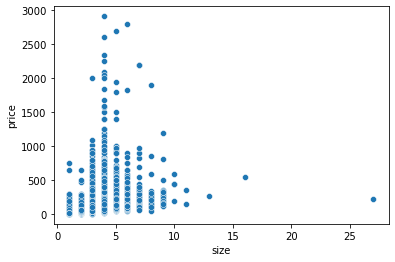

In [8]:
sns.scatterplot(x=df['size'],y=df['price'])

#### <font color='purple'>We observe from the below Scatter plot between balcony and Price there exists no Correlation between them and Linear Models cannot be used to predict the prices</color>

<AxesSubplot:xlabel='balcony', ylabel='price'>

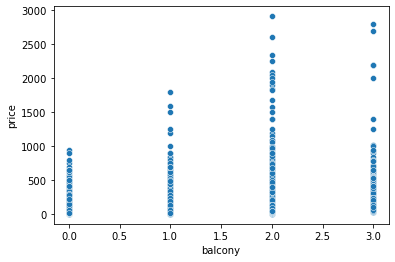

In [9]:
sns.scatterplot(x=df['balcony'],y=df['price'])

In [10]:
#Placing the price column at the end
prices=df['price']
del df['price']
df['price']=prices

## 2)Model Building

In [11]:
#Test Train Split
x=df.iloc[:,3:-1]
y=df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

### <font color='purple'>Multiple Linear Regression Model(To Show that MLR doesn't work well in our case)</font>

In [16]:
model=LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [17]:
prediction = model.predict(x_test)
mean_absolute_percentage_error(y_test,prediction)

0.4906071430244997

### <font color='purple'>We Observe that Multiple Linear Regression Model doesn't work well </font>

### <font color='green'>Thus we plan to implement other models which help us in predicting the results better </font>

### <font color='purple'>1)Random Forest Regressor</font>

In [18]:
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
prediction = regressor.predict(x_test)
mean_absolute_percentage_error(y_test,prediction)

0.23546042389205463

### <font color='green'>We Observe that RandomForestRegressor works pretty well and the MAPE is also reduced </font>

### <font color='purple'>2)Decision Tree Regressor</font>

In [19]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(x_train,y_train)
predicted=regressor.predict(x_test)
mean_absolute_percentage_error(y_test,predicted)

0.26345238890124395

### <font color='green'>We Observe that DecisionTreeRegressor works better than MLR but not as good as RandomForestRegressor </font>

### <font color='purple'>3)Adaboost with Decision Tree Regressor</font>

In [24]:
regr2 = AdaBoostRegressor(DecisionTreeRegressor())
regr2.fit(x_train,y_train)
predict=regr2.predict(x_test)
mean_absolute_percentage_error(y_test,predict)

0.25422834782679304

### <font color='green'>We Observe that Adaboost with Decision Tree Regressor works better than MLR and Decision Tree Regressor but not as good as RandomForestRegressor </font>

### <font color='purple'>4)XG Boost</font>

In [20]:
xgb_r = xg.XGBRegressor()
xgb_r.fit(x_train,y_train)
predicted=xgb_r.predict(x_test)
mean_absolute_percentage_error(y_test,predicted)

0.30633897236309876

### <font color='green'>We Observe that XGBRegressor works better than MLR but not as good as first three Models </font>

### <font color='purple'>5)KNeighborsRegressor</font>

In [21]:
neigh = KNeighborsRegressor()
neigh.fit(x_train,y_train)
a=neigh.predict(x_test)
mean_absolute_percentage_error(y_test,a)

0.33104165575603156

### <font color='green'>We Observe that KNeighborsRegressor works better than MLR but not as good as first four Models </font>

### <font color='purple'>6)MLP Regressor</font>

In [23]:
mlps=MLPRegressor()
mlps.fit(x_train,y_train)
pred=mlps.predict(x_test)
mean_absolute_percentage_error(y_test,pred)

0.39248293748550367

### <font color='green'>We Observe that MLP Regressor works better than MLR but not as good as first five Models </font>